# Import necessary libraries:

In [24]:
from keras.saving.save import load_model
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import joblib
from sklearn.cluster import KMeans
import warnings

warnings.filterwarnings("ignore")

# Load the model:

In [2]:
model = load_model("models/combined-u/encoder.h5", compile=False)

# Load the data:

In [4]:
data = pd.read_pickle("datasets/combined-u/x_train_alpha(0.005).pkl")

# Encode the data:

In [5]:
encoded_data = model.predict(data)

186/186 [==============================] - 2s 1ms/step


# Use Average Silhouette method to find the optimal number of clusters using KMeans:

In [6]:
# Define clustering loop
max_clusters = 30
silhouette = np.zeros(max_clusters)

for n_clusters in range(2, max_clusters):
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(encoded_data)
    silhouette[n_clusters] = metrics.silhouette_score(
        encoded_data, cluster_labels, metric="euclidean"
    )

# Determine the optimal number of clusters
optimal_n_clusters = np.argmax(silhouette)
print("Optimal number of clusters:", optimal_n_clusters)

Optimal number of clusters: 12


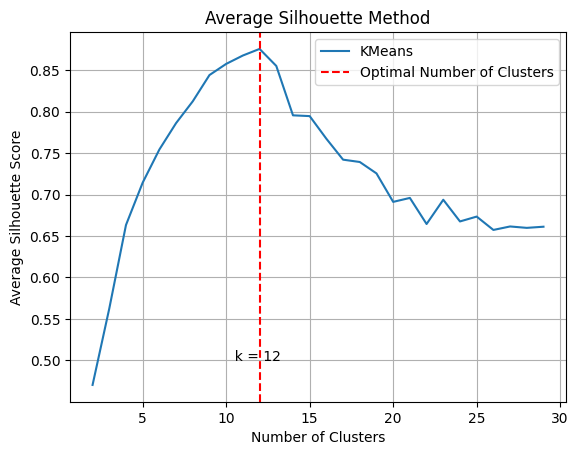

In [7]:
# Plot the silhouette scores
plt.plot(np.arange(2, max_clusters), silhouette[2:], label="KMeans")
plt.xlabel("Number of Clusters")
plt.ylabel("Average Silhouette Score")
plt.title("Average Silhouette Method")

# annotate the optimal number of clusters with vertical dotted line and write the number of clusters
plt.axvline(x=optimal_n_clusters,
            linestyle="--" ,
            color="red",
            label='Optimal Number of Clusters')
plt.annotate('  k = %d' % optimal_n_clusters,
             xy=(optimal_n_clusters-2, 0.5),
             xytext=(optimal_n_clusters-2, 0.5)
)

plt.grid()
plt.legend()
plt.show()

# Use Elbow method to find the optimal number of clusters using KMeans:

In [8]:
# Define range of cluster numbers to try
max_clusters = 30

# Calculate WCSS for each cluster number using KMeans
wcss_kmeans = []
for n_clusters in range(2, max_clusters):
    kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
    kmeans.fit(encoded_data)
    wcss_kmeans.append(kmeans.inertia_)

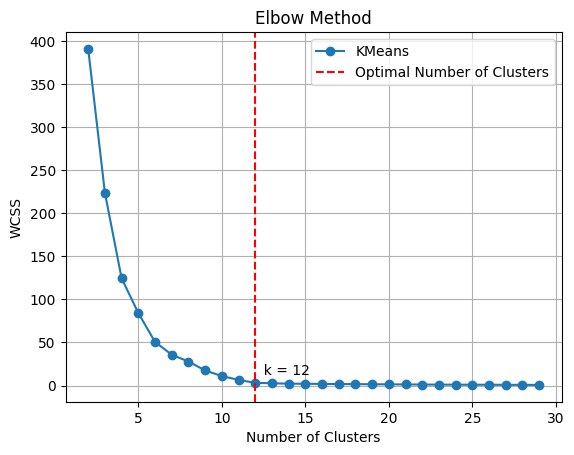

In [9]:
# Plot the WCSS for each cluster number
plt.plot(range(2, max_clusters), wcss_kmeans, marker='o', label="KMeans")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.title("Elbow Method")

# annotate the optimal number of clusters with vertical dotted line and write the number of clusters
plt.axvline(x=optimal_n_clusters,
            linestyle="--" ,
            color="red",
            label='Optimal Number of Clusters')
plt.annotate('  k = %d' % optimal_n_clusters,
             xy=(optimal_n_clusters, optimal_n_clusters),
             xytext=(optimal_n_clusters, optimal_n_clusters)
)

plt.grid()
plt.legend()
plt.show()

# Train kmeans with the optimal number of clusters:

In [10]:
kmeans = KMeans(n_clusters=optimal_n_clusters, init="k-means++", random_state=42)
kmeans.fit(encoded_data)

KMeans(n_clusters=12, random_state=42)

In [15]:
clusters = kmeans.predict(encoded_data)

# Save the users of each cluster:

In [21]:
# save each cluster in a separate dataframe
clusters_df = pd.DataFrame(clusters, columns=["cluster"])
clusters_df["user"] = data.index
clusters_df = clusters_df.sort_values(by="cluster")
clusters_df = clusters_df.set_index("cluster")
clusters_df = clusters_df.groupby("cluster")["user"].apply(list)
clusters_df = clusters_df.to_frame()
clusters_df.to_pickle("datasets/combined-u/users-clusters.pkl")
print(clusters_df)


                                                      user
cluster                                                   
0        [3854, 5141, 4074, 4072, 2245, 4070, 4069, 224...
1        [3163, 3171, 1709, 4547, 1702, 4549, 3739, 455...
2        [2583, 4085, 2630, 1027, 357, 2883, 2221, 1037...
3        [3527, 2658, 5880, 3215, 3735, 5678, 3546, 272...
4        [4591, 4634, 4630, 3728, 5435, 4533, 3385, 593...
5        [4610, 4937, 2691, 472, 463, 4611, 3749, 2678,...
6        [800, 5316, 4461, 1821, 4844, 953, 5198, 4845,...
7        [1508, 4700, 1504, 127, 1257, 4922, 1498, 4916...
8        [2925, 1677, 4516, 3787, 2395, 5356, 1730, 745...
9        [4662, 1756, 609, 5907, 3310, 4585, 4573, 2785...
10       [3081, 3067, 2819, 3204, 3472, 3059, 5789, 15,...
11       [3265, 1443, 4567, 1700, 4770, 4587, 4596, 460...


# Save the Kmeans model with the optimal number of clusters:

In [22]:
joblib.dump(kmeans, "models/combined-u/kmeans.pkl")

['models/combined-u/kmeans.pkl']